In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


ROC-AUC 점수: 0.9047


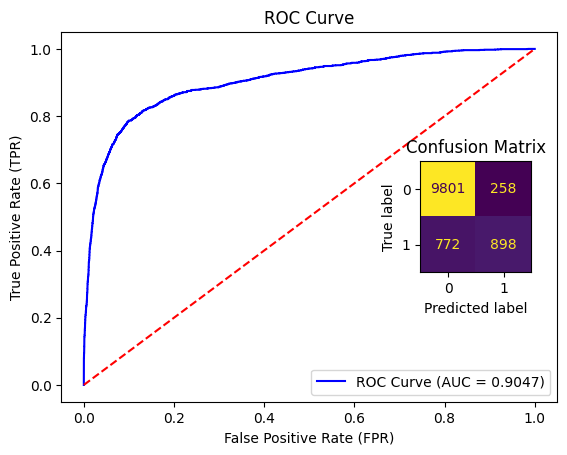

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

# 삭제 전 ID 저장
train_idx = train['id']
test_idx = test['id']

train = train.drop(columns=['id'])
test = test.drop(columns=['id'])


# 데이터 준비
y = train['loan_status']  # 타겟 변수
X = train.drop('loan_status', axis=1)  # 특징 변수

# 학습 및 검증 데이터셋 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 범주형 및 수치형 변수 정의
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 특정 문자열을 수치형 컬럼에서 제거
remove_strings = ['person_age']
numerical_cols = [item for item in numerical_cols if item not in remove_strings]

# 전처리 및 모델 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # 수치형 컬럼에 대해 StandardScaler 적용
        # ('cat', OrdinalEncoder(), categorical_cols)  # 범주형 컬럼에 대해 OrdinalEncoder 적용 0.88
         ('cat', OneHotEncoder(drop='first'), categorical_cols)  # 범주형 컬럼에 대해 OneHotEncoder 적용
        
    ]
)

logistic_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(solver='liblinear')  # 로지스틱 회귀 모델
)

# 하이퍼파라미터 튜닝 (ROC-AUC 스코어 기준)
param_distributions = {
    'logisticregression__C': uniform(0.01, 10),  # 정규화 강도
    'logisticregression__penalty': ['l1', 'l2']  # 정규화 방식
}

random_search = RandomizedSearchCV(
    logistic_pipeline, 
    param_distributions, 
    n_iter=100, 
    cv=2, 
    random_state=42, 
    n_jobs=-1, 
    scoring='roc_auc'  # ROC-AUC를 기준으로 스코어링
)

# 모델 학습
random_search.fit(X_train, y_train)

# 검증 세트에 대한 예측 확률 계산
y_val_probs = random_search.predict_proba(X_val)[:, 1]  # 클래스 1(양성 클래스)에 대한 확률 추출

# ROC-AUC 점수 계산 및 출력
roc_auc = roc_auc_score(y_val, y_val_probs)
print(f'ROC-AUC 점수: {roc_auc:.4f}')

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)

# ROC 곡선 그리기
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')  # 랜덤 추측선
ax.set_xlabel('False Positive Rate (FPR)')  # 위양성 비율
ax.set_ylabel('True Positive Rate (TPR)')  # 진양성 비율
ax.set_title('ROC Curve')
ax.legend(loc='lower right')

# 그리드 제거
ax.grid(False)

# 검증 데이터에 대한 예측 값 생성
y_val_preds = random_search.best_estimator_.predict(X_val)

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_preds)

# ROC 곡선 안에 혼동 행렬 삽입
ax_inset = inset_axes(ax, width="30%", height="30%", loc="center right")  # 위치 조정 가능
ConfusionMatrixDisplay(cm).plot(ax=ax_inset, colorbar=False)
ax_inset.grid(False)  # 혼동 행렬에 그리드 제거
ax_inset.set_title('Confusion Matrix')  # 작은 창에 제목 추가

# 그래프 보여주기
plt.show()

# 테스트 데이터 예측 및 제출 파일 저장
test = test.loc[:, categorical_cols + numerical_cols]
now = datetime.now()

# 테스트 데이터에 대한 예측 수행
submission['loan_status'] = np.round(random_search.best_estimator_.predict_proba(test)[:, 1], 2)
submission.to_csv(f'result_{now.strftime("%Y-%m-%d_%H-%M-%S")}.csv', index=False)